In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

## Load the data 
40 subjects, each with 10 pictures

In [2]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content')

In [3]:
# Set directory to access pictures
face_data = '/content/Faces' 

In [4]:
# Initialize lists to hold image data (flattened for Random Forest and Logistic Regression and original 2D for CNN) and its label
X_data = []
y_data = []
X_data_original = []

In [5]:
# Iterate through dataset directory
for dir_name in os.listdir(face_data):
    if os.path.isdir(os.path.join(face_data, dir_name)):
        label = dir_name
        for img_name in os.listdir(os.path.join(face_data, dir_name)):
            img_path = os.path.join(face_data, dir_name, img_name)
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            img_flattened = img_array.flatten() # flatten from 2D array to 1D array
            X_data.append(img_flattened)
            y_data.append(label)
            X_data_original.append(img_array) # keep original 2D array

## Exploratory Data Analysis

### Check a specific subject's image set

In [6]:
# Accessing the data for a specific set of images
set_number = 's14' 
set_images = [img for img, label in zip(X_data, y_data) if label == set_number]

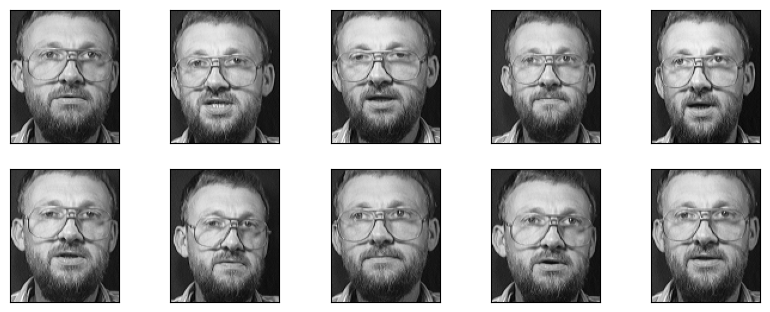

In [7]:
# Print the images from the specified set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
plt.show()

### Image Stats

In [8]:
# Initialize a dictionary to hold average pixel intensities for each class
average_pixel_intensities = {}

# Iterate over each class
for class_name in set(y_data):
    # Find all images belonging to this class
    class_images = [image for image, label in zip(X_data, y_data) if label == class_name]
    
    # Calculate average pixel intensity for this class
    average_pixel_intensity = np.mean([np.mean(image) for image in class_images])
    
    # Store the result in our dictionary
    average_pixel_intensities[class_name] = average_pixel_intensity

# Print the results
for class_name, avg_intensity in average_pixel_intensities.items():
    print(f"Average pixel intensity for {class_name}: {avg_intensity}")

Average pixel intensity for s33: 92.42089479813664
Average pixel intensity for s19: 120.02870729813665
Average pixel intensity for s32: 125.42356366459626
Average pixel intensity for s5: 130.87773680124224
Average pixel intensity for s8: 120.13745147515526
Average pixel intensity for s9: 113.32507763975154
Average pixel intensity for s7: 112.24663237577639
Average pixel intensity for s18: 135.5274650621118
Average pixel intensity for s35: 122.07861995341617
Average pixel intensity for s3: 115.87922166149069
Average pixel intensity for s21: 101.22831909937888
Average pixel intensity for s2: 112.65321234472049
Average pixel intensity for s29: 91.63590838509317
Average pixel intensity for s11: 102.36776979813665
Average pixel intensity for s6: 138.23907220496895
Average pixel intensity for s40: 123.42201086956523
Average pixel intensity for s22: 85.1676921583851
Average pixel intensity for s30: 99.23293866459628
Average pixel intensity for s15: 112.20925854037266
Average pixel intensity f

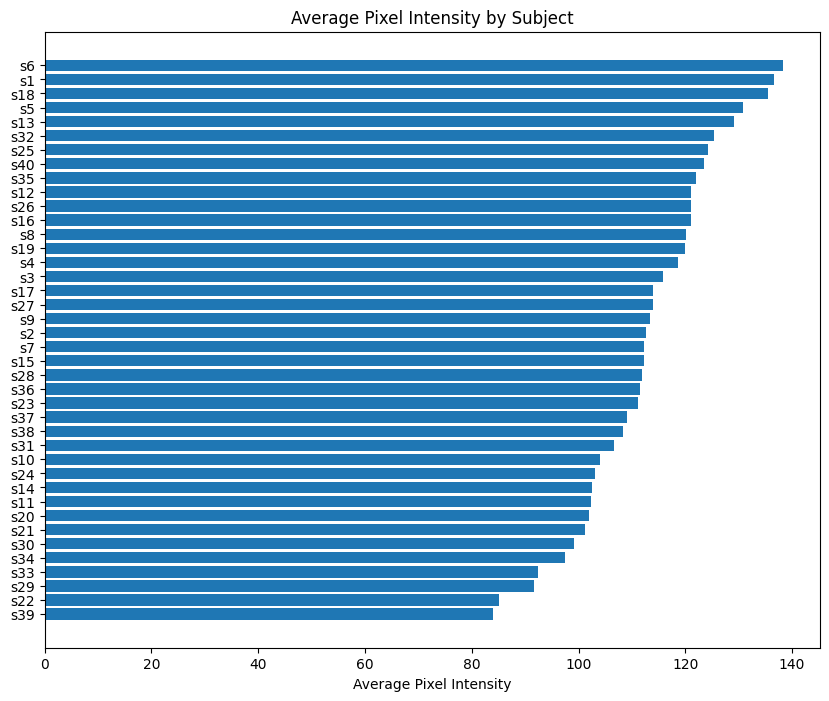

In [9]:
# Create DataFrame from dictionary
average_pixel_intensities_df = pd.DataFrame(list(average_pixel_intensities.items()), columns=['Subject', 'Average Pixel Intensity'])

# Sort DataFrame by 'Average Pixel Intensity'
average_pixel_intensities_df = average_pixel_intensities_df.sort_values('Average Pixel Intensity')

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(average_pixel_intensities_df['Subject'], average_pixel_intensities_df['Average Pixel Intensity'])
plt.xlabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Subject')
plt.show()

# Machine Learning Models

In [10]:
# Training and Testing Split (used for both Random Forest and Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1, stratify=y_data)

## Random Forest Classifier

Reference: https://notebook.community/mbeyeler/opencv-machine-learning/notebooks/10.03-Using-Random-Forests-for-Face-Recognition

In [11]:
# Assign Random Forest model 
RFmodel = RandomForestClassifier()

# Fit the Random Forest Classifier on the training data
RFmodel.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
# Make predictions on the test set
RF_y_pred = RFmodel.predict(X_test)

In [13]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 93.75%


In [14]:
# Generate a confusion matrix for Random Forest model
RFconfusion_matrix = confusion_matrix(y_test, RF_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(RFconfusion_matrix)

Logistic Regression Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [15]:
# Print the classification report for Random Forest model
RFclassification_report = classification_report(y_test, RF_y_pred)
print(f"Random Forest Classification Report:")
print(RFclassification_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      1.00      1.00         2
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       0.67      1.00      0.80         2
         s15       1.00      1.00      1.00         2
         s16       1.00      1.00      1.00         2
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       0.67      1.00      0.80         2
          s2       1.00      1.00      1.00         2
         s20       1.00      1.00      1.00         2
         s21       1.00      1.00      1.00         2
         s22       1.00      0.50      0.67         2
         s23       1.00      1.00      1.00         2
         s24       1.00      1.00      1.00 

In [16]:
# Finding Misclassified images in Random Forest

# Convert y_test and RF_y_pred to numpy arrays
y_test_array = np.array(y_test)
RF_y_pred_array = np.array(RF_y_pred)

# Find indices of misclassified examples
RFmisclassified = np.where(y_test_array != RF_y_pred_array)[0]

# Create dataframe of misclassified examples
RFmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[RFmisclassified],
    'Predicted Label': RF_y_pred_array[RFmisclassified]
})

RFmisclassified_df

,True Label,Predicted Label
0,s32,s19
1,s40,s5
2,s36,s7
3,s22,s14
4,s37,s28


##Logistic Regression

In [17]:
# Scale the data for Logistic Regression
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Assign Logistic Regression model
LRmodel = LogisticRegression(max_iter=2000)

# Fit Logistic Regression model using training data
LRmodel.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [19]:
# Make a prediction using the testing data
LR_y_pred = LRmodel.predict(X_test_scaled)

In [20]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 98.75%


In [21]:
# Generate a confusion matrix for Logistic Regression model
LRconfusion_matrix = confusion_matrix(y_test, LR_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(LRconfusion_matrix)

Logistic Regression Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [22]:
# Print the classification report for Logistic Regression model
LRclassification_report = classification_report(y_test, LR_y_pred)
print(f"Logistic Regression Classification Report:")
print(LRclassification_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      1.00      1.00         2
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         2
         s15       1.00      1.00      1.00         2
         s16       1.00      1.00      1.00         2
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         2
         s20       1.00      1.00      1.00         2
         s21       1.00      1.00      1.00         2
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         2
         s24       1.00      1.00     

In [23]:
# Finding Misclassified images in Logistic Regression

# Convert y_test and LR_y_pred to numpy arrays
y_test_array = np.array(y_test)
LR_y_pred_array = np.array(LR_y_pred)

# Find indices of misclassified examples
LRmisclassified = np.where(y_test_array != LR_y_pred_array)[0]

# Create dataframe of misclassified examples
LRmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[LRmisclassified],
    'Predicted Label': LR_y_pred_array[LRmisclassified]
})

LRmisclassified_df


,True Label,Predicted Label
0,s40,s5


# Convolutional Neural Network (CNN) 
Reference: https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5

In [24]:
# Create numpy array
X_data_original = np.array(X_data_original)
y_data = np.array(y_data)

# Split the original image data into training and testing sets, use random_state 1
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_data_original, y_data, test_size=0.2, random_state=1, stratify=y_data)

print('Original Images:')
print('X_train_original = %s, y_train_original = %s' % (X_train_original.shape, y_train_original.shape))
print('X_test_original = %s, y_test_original = %s' % (X_test_original.shape, y_test_original.shape))

Original Images:
X_train_original = (320, 112, 92), y_train_original = (320,)
X_test_original = (80, 112, 92), y_test_original = (80,)


In [25]:
# Reshaping the array to become 4-dimensional
X_train_original  = X_train_original.reshape(X_train_original.shape[0], 112, 92, 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], 112, 92, 1)

print('After reshaping, X_train_original is :', X_train_original.shape)
print('X_train_original contains', X_train_original.shape[0], "images")
print('X_test_original contains', X_test_original.shape[0], "images")

After reshaping, X_train_original is : (320, 112, 92, 1)
X_train_original contains 320 images
X_test_original contains 80 images


In [26]:
# To ensure decimal points after division
X_train_original = X_train_original.astype('float32')
X_test_original = X_test_original.astype('float32')

# Normalizing the RGB codes by dividing it by the max RGB value
X_train_original /= 255
X_test_original /= 255

In [27]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

In [28]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

In [29]:
# Create a dataframe to store the results for model optimization
results = pd.DataFrame(columns=["Model_Version", "Test_Loss", "Test_Accuracy"])

### CNN Model Version 1 - original codeblock from referenced link

In [30]:
# Creating a sequential model named and adding layers to it
CNN_v1 = models.Sequential()
CNN_v1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v1.add(layers.MaxPooling2D((2, 2)))
CNN_v1.add(layers.Flatten())
CNN_v1.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v1.add(layers.Dense(40, activation='softmax'))

In [31]:
# Compile the model
CNN_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Fit the model
history = CNN_v1.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
y_pred_v1 = CNN_v1.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v1
classification_report_v1 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v1, axis=1), zero_division=0)
print("CNN_v1 Classification Report:")
print(classification_report_v1)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v1
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v1 model
CNN_v1.save("CNN_v1.h5")

Epoch 1/10
8/8 [==============================] - 3s 232ms/step - loss: 26.6284 - accuracy: 0.0156 - val_loss: 13.9845 - val_accuracy: 0.0781
Epoch 2/10
8/8 [==============================] - 2s 278ms/step - loss: 7.1834 - accuracy: 0.0625 - val_loss: 3.6700 - val_accuracy: 0.0312
Epoch 3/10
8/8 [==============================] - 2s 195ms/step - loss: 3.6345 - accuracy: 0.0312 - val_loss: 3.6578 - val_accuracy: 0.0469
Epoch 4/10
8/8 [==============================] - 2s 198ms/step - loss: 3.6118 - accuracy: 0.0391 - val_loss: 3.6664 - val_accuracy: 0.0156
Epoch 5/10
8/8 [==============================] - 1s 189ms/step - loss: 3.6329 - accuracy: 0.0195 - val_loss: 3.6893 - val_accuracy: 0.0156
Epoch 6/10
8/8 [==============================] - 2s 199ms/step - loss: 3.6692 - accuracy: 0.0391 - val_loss: 3.6408 - val_accuracy: 0.0312
Epoch 7/10
8/8 [==============================] - 2s 199ms/step - loss: 3.6469 - accuracy: 0.0352 - val_loss: 3.6917 - val_accuracy: 0.0000e+00
Epoch 8/10
8/8

<ipython-input-32-5e4559fa928d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 2 - added a convolutional layer

In [33]:
# Creating a sequential model named and adding layers to it
CNN_v2 = models.Sequential()
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))
CNN_v2.add(layers.Flatten())
CNN_v2.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v2.add(layers.Dense(40, activation='softmax'))

In [34]:
# Compile the model
CNN_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Fit the model
history = CNN_v2.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
y_pred_v2 = CNN_v2.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v2
classification_report_v2 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v2, axis=1))
print("CNN_v2 Classification Report:")
print(classification_report_v2)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v2
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v2 model
CNN_v2.save("CNN_v2.h5")

Epoch 1/10
8/8 [==============================] - 3s 275ms/step - loss: 5.2834 - accuracy: 0.0312 - val_loss: 3.9166 - val_accuracy: 0.0312
Epoch 2/10
8/8 [==============================] - 2s 249ms/step - loss: 3.6680 - accuracy: 0.0664 - val_loss: 3.6869 - val_accuracy: 0.0312
Epoch 3/10
8/8 [==============================] - 2s 236ms/step - loss: 3.5599 - accuracy: 0.0938 - val_loss: 3.5780 - val_accuracy: 0.0156
Epoch 4/10
8/8 [==============================] - 3s 358ms/step - loss: 3.2502 - accuracy: 0.2383 - val_loss: 3.3153 - val_accuracy: 0.1875
Epoch 5/10
8/8 [==============================] - 2s 238ms/step - loss: 2.5728 - accuracy: 0.5273 - val_loss: 2.7614 - val_accuracy: 0.3906
Epoch 6/10
8/8 [==============================] - 2s 235ms/step - loss: 1.7580 - accuracy: 0.6875 - val_loss: 2.2400 - val_accuracy: 0.3906
Epoch 7/10
8/8 [==============================] - 2s 239ms/step - loss: 1.0473 - accuracy: 0.8359 - val_loss: 1.5396 - val_accuracy: 0.6250
Epoch 8/10
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 63ms/step - loss: 0.8011 - accuracy: 0.8500


<ipython-input-35-ace8be32a4ee>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 3 - doubled epochs from 10 to 20

In [36]:
# Creating a sequential model named and adding layers to it
CNN_v3 = models.Sequential()
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v3.add(layers.MaxPooling2D((2, 2)))
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v3.add(layers.MaxPooling2D((2, 2)))
CNN_v3.add(layers.Flatten())
CNN_v3.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v3.add(layers.Dense(40, activation='softmax'))

In [37]:
# Compile the model
CNN_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Fit the model
history = CNN_v3.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
y_pred_v3 = CNN_v3.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v3
classification_report_v3 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v3, axis=1))
print("CNN_v3 Classification Report:")
print(classification_report_v3)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v3
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v3 model
CNN_v3.save("CNN_v3.h5")

Epoch 1/20
8/8 [==============================] - 3s 259ms/step - loss: 5.6616 - accuracy: 0.0234 - val_loss: 3.7549 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 2s 244ms/step - loss: 3.7054 - accuracy: 0.0391 - val_loss: 3.6669 - val_accuracy: 0.0156
Epoch 3/20
8/8 [==============================] - 2s 242ms/step - loss: 3.6292 - accuracy: 0.0508 - val_loss: 3.5981 - val_accuracy: 0.0156
Epoch 4/20
8/8 [==============================] - 2s 241ms/step - loss: 3.4673 - accuracy: 0.1914 - val_loss: 3.4586 - val_accuracy: 0.0781
Epoch 5/20
8/8 [==============================] - 2s 234ms/step - loss: 3.2138 - accuracy: 0.2188 - val_loss: 3.2118 - val_accuracy: 0.1406
Epoch 6/20
8/8 [==============================] - 3s 359ms/step - loss: 2.7609 - accuracy: 0.3984 - val_loss: 2.8934 - val_accuracy: 0.2188
Epoch 7/20
8/8 [==============================] - 2s 243ms/step - loss: 2.1964 - accuracy: 0.5273 - val_loss: 2.4239 - val_accuracy: 0.4219
Epoch 8/20
8/8 [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 47ms/step - loss: 0.5079 - accuracy: 0.8875


<ipython-input-38-8e8af20091f0>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 4 - added a third convolutional layer

In [39]:
# Creating a sequential model named and adding layers to it
CNN_v4 = models.Sequential()
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))
CNN_v4.add(layers.Flatten())
CNN_v4.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.Dense(40, activation='softmax'))

In [40]:
# Compile the model
CNN_v4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Fit the model
history = CNN_v4.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
y_pred_v4 = CNN_v4.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v4
classification_report_v4 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v4, axis=1))
print("CNN_v4 Classification Report:")
print(classification_report_v4)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v4
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v4 model
CNN_v4.save("CNN_v3.h5")

Epoch 1/20
8/8 [==============================] - 3s 275ms/step - loss: 3.7613 - accuracy: 0.0430 - val_loss: 3.6739 - val_accuracy: 0.0156
Epoch 2/20
8/8 [==============================] - 2s 259ms/step - loss: 3.5802 - accuracy: 0.0820 - val_loss: 3.6912 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 2s 248ms/step - loss: 3.4367 - accuracy: 0.1172 - val_loss: 3.5089 - val_accuracy: 0.0625
Epoch 4/20
8/8 [==============================] - 3s 359ms/step - loss: 3.0365 - accuracy: 0.2109 - val_loss: 3.2369 - val_accuracy: 0.1406
Epoch 5/20
8/8 [==============================] - 2s 253ms/step - loss: 2.4335 - accuracy: 0.4336 - val_loss: 2.5881 - val_accuracy: 0.3281
Epoch 6/20
8/8 [==============================] - 2s 254ms/step - loss: 1.6340 - accuracy: 0.6758 - val_loss: 2.0805 - val_accuracy: 0.4531
Epoch 7/20
8/8 [==============================] - 2s 259ms/step - loss: 0.9619 - accuracy: 0.7852 - val_loss: 1.3651 - val_accuracy: 0.6250
Epoch 8/20
8/8 [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 51ms/step - loss: 0.4262 - accuracy: 0.9125


<ipython-input-41-a6c36050f4aa>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


In [42]:
print(results)

  Model_Version  Test_Loss  Test_Accuracy
0        CNN_v1   3.688948         0.0250
1        CNN_v2   0.801116         0.8500
2        CNN_v3   0.507907         0.8875
3        CNN_v4   0.426226         0.9125


## Visualizations for CNN

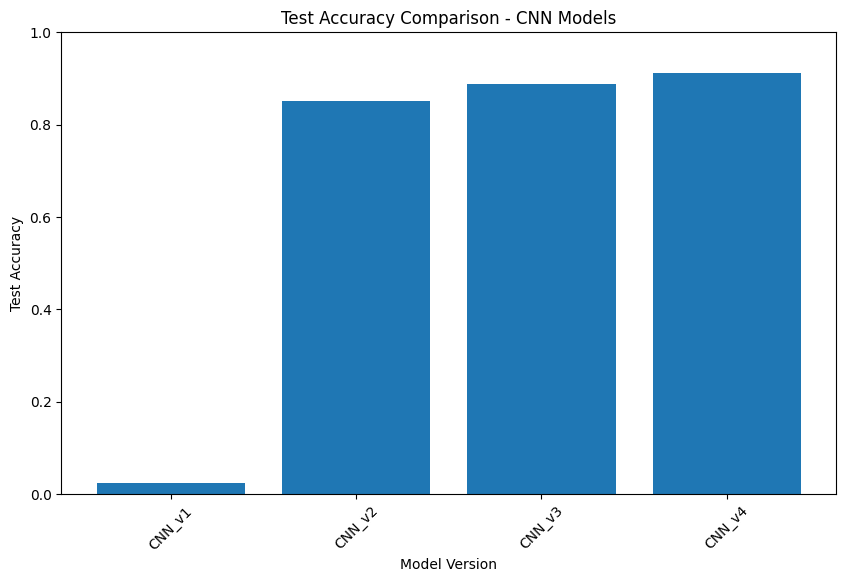

In [52]:
# Plot the test accuracy for each CNN model version
plt.figure(figsize=(10, 6))
plt.bar(results["Model_Version"], results["Test_Accuracy"])
plt.xlabel("Model Version")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison - CNN Models")
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()

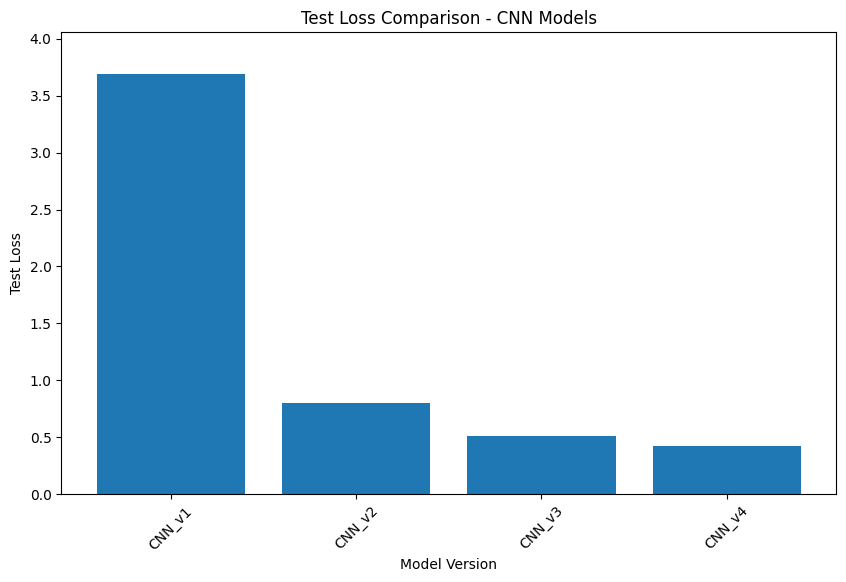

In [44]:
# Plot the test loss for each CNN model version
plt.figure(figsize=(10, 6))
plt.bar(results["Model_Version"], results["Test_Loss"])
plt.xlabel("Model Version")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison - CNN Models")
plt.ylim([0, max(results["Test_Loss"]) * 1.1])
plt.xticks(rotation=45)
plt.show()

# Comparative Visualizations

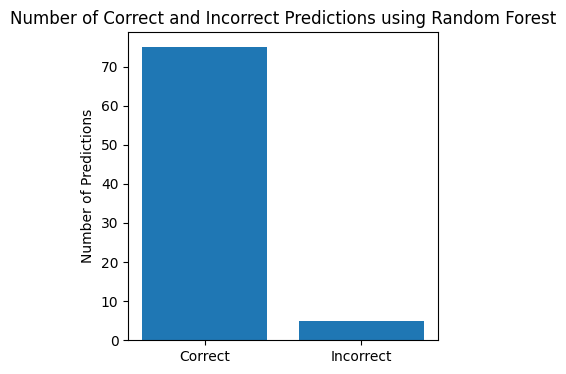

In [45]:
# Calculate number of correct and incorrect predictions using Random Forest
correct_predictions = sum(y_test_array == RF_y_pred_array)
incorrect_predictions = sum(y_test_array != RF_y_pred_array)

# Create bar plot
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Random Forest")
plt.show()

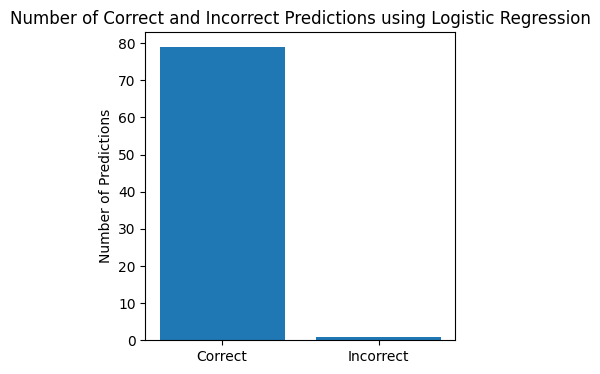

In [46]:
# Calculate number of correct and incorrect predictions using Logistic Regression
correct_predictions = sum(y_test_array == LR_y_pred_array)
incorrect_predictions = sum(y_test_array != LR_y_pred_array)

# Create bar plot
plt.figure(figsize=(4, 4))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Logistic Regression")
plt.show()

In [47]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 93.75%


In [48]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 98.75%


## !! add in bar graph to see all three models accuracy performance

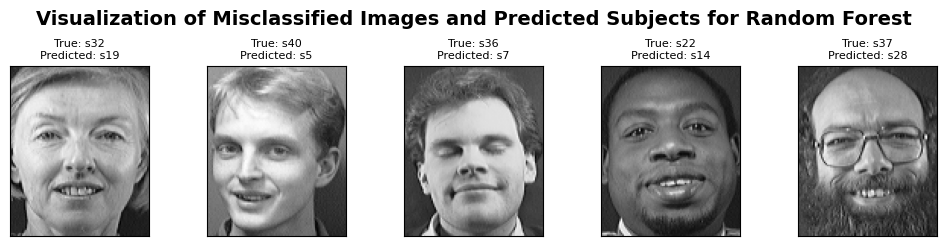

In [49]:
# Display misclassified images along with text indicating True and Predicted subjects for Random Forest

# Iterate through misclassified images and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(RFmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = RF_y_pred_array[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)
    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Random Forest", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

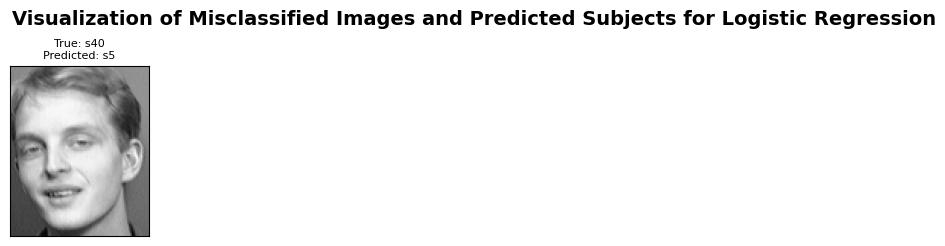

In [50]:
# Display misclassified images along with text indicating True and Predicted subjects for Logistic Regression

# Iterate through misclassified indices and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(LRmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = LR_y_pred[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)
    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Logistic Regression", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
